In [1]:
import lensing
from importlib import reload
reload(lensing)
from lensing import *
import matplotlib.pyplot as plt
from astropy.convolution import convolve, AiryDisk2DKernel, Gaussian2DKernel
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [2]:
x_deflections = open_fits('dplx.fits')
y_deflections = open_fits('dply.fits')
dx_header = fits.open('dplx.fits')[0].header

In [3]:
w = WCS(dx_header)
c = SkyCoord(ra=93.9795443, dec=-57.7723101, unit='deg',frame="fk5")
arc_center = w.world_to_pixel(c)
print(f"arc center pixel coordinates: {arc_center[0]}, {arc_center[1]}")

arc center pixel coordinates: 831.4647106641776, 2209.6455239446627


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
dx_header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3000 / length of data axis 1                          
NAXIS2  =                 3000 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                   0. / BZERO                                          
BSCALE  =                   1. / BSCALE                                         
EQUINOX =                2000. / EQUINOX                                        
RADECSYS= 'FK5     '           / RADECSYS                                       
CTYPE1  = 'RA---TAN'        

In [5]:
import astropy.units as u
w.proj_plane_pixel_scales()[0].to(u.arcsec)

<Quantity 0.04001334 arcsec>

In [6]:
deflections_grid = grid((0,0),3000,0.040013338)

## Convergence and Magnification

In [7]:
# lens redshift 0.972
magnification = magnification_from_deflections(deflections_grid, x_deflections, y_deflections, deflections_grid)
convergence = convergence_from_deflections(deflections_grid, x_deflections, y_deflections, deflections_grid)

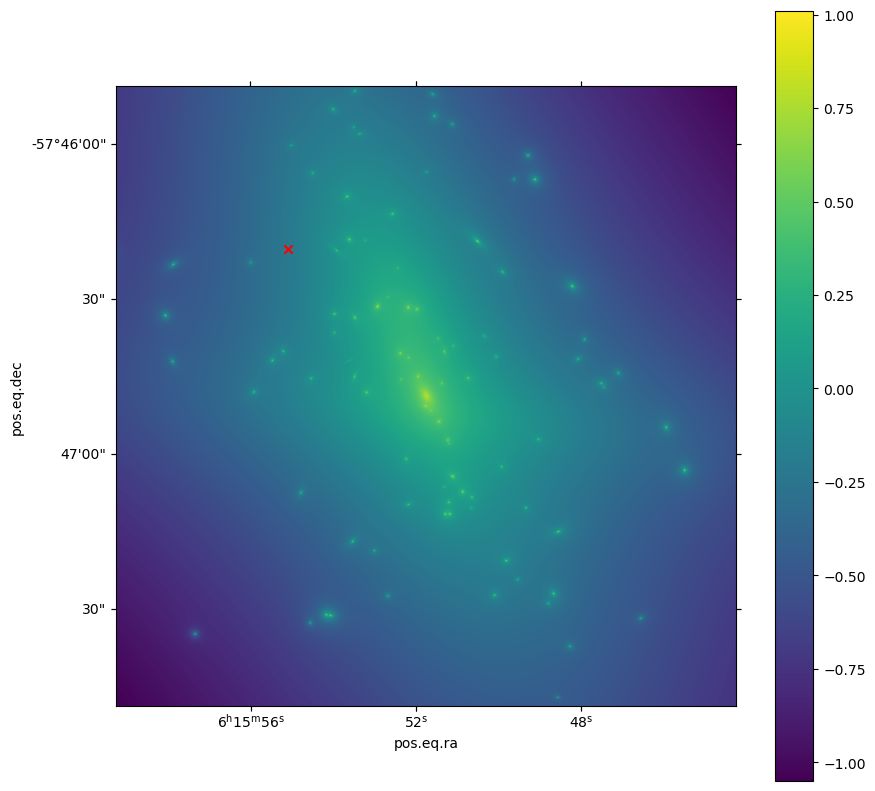

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=w)
ax.imshow(np.log10(np.flip(convergence,axis=0)))
ax.scatter(93.9795443,-57.7723101,marker='x',color='red',transform=plt.gca().get_transform('world'))
fig.colorbar(ax.images[0], ax=ax)

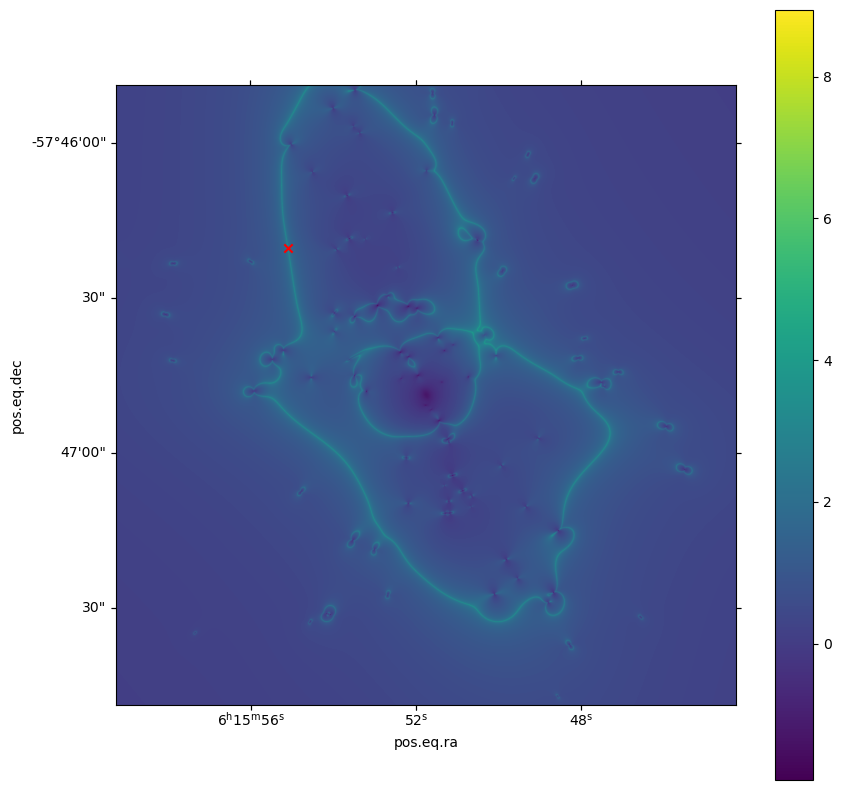

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=w)
ax.imshow(np.log10(np.flip(magnification,axis=0)))
ax.scatter(93.9795443,-57.7723101,marker='x',color='red',transform=plt.gca().get_transform('world'))
fig.colorbar(ax.images[0], ax=ax)

## Lensing

In [10]:
from lum_lookup import lum_look_up_table
from astropy.cosmology import FlatLambdaCDM

def ang_size(phys_size, lum_dist, redshift):
    """
    angsize in arcesconds
    """
    size_dist = lum_dist / (1 + redshift) ** 2
    # 2.06e5=180*60*60/pi
    return (phys_size / size_dist) * (2.06e5)


def zshifted_flux_jy(lum, lum_dis, wav_angs=1500):
    """
    need lum distance in parsecs
    """
    return 7.5e10 * (wav_angs / 1500) ** 2 * (lum / (4 * np.pi * (lum_dis * 3e18) ** 2))

# let's grab the star cluster data
# fid format: ages: 2, x,y,z: 4,5,6
# pos format: ages: 1, x,y,z: 2,3,4

cosmo = FlatLambdaCDM(H0=68 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

#d_lum = 117103e6  # pc
z = 10.1
d_lum=cosmo.luminosity_distance(z).value*1e6

# construct what the galaxy would look like in the sky at a given redshift
# at z=10 -> 0.03" (Nircam) is 127 pc
gal_size = ang_size(200, d_lum, z)

bins = 1000

arsec_per_pixel = (2 * gal_size) / bins

def create_source_image(filename,filetype="fid"):
    particle_data = np.loadtxt(
        filename
    )
    if filetype == "fid":
        ages=particle_data[:, 2]-15.0
        ages=np.where(ages>0., ages, 0.1)
        x_viewed = ang_size(particle_data[:, 4], d_lum, z)
        y_viewed = ang_size(particle_data[:, 5], d_lum, z)
    elif filetype == "pos":
        ages=particle_data[:, 1]
        x_viewed = ang_size(particle_data[:, 2], d_lum, z)
        y_viewed = ang_size(particle_data[:, 3], d_lum, z)
    
    flux0=lum_look_up_table(
            stellar_ages=ages*1e6,
            table_link="./Starburst99/l1500_top_heavy_lowmet.txt",
            column_idx=1,
            log=False,
        )
    flux = zshifted_flux_jy(flux0, d_lum, 1500)

    # surface brightness in 10xnJy/arcsec^2
    flux=1e8*flux/(arsec_per_pixel)**2

    lums1, xedges, yedges = np.histogram2d(
        x_viewed,
        y_viewed,
        bins=bins,
        weights=flux,
        range=[[-gal_size, gal_size], [-gal_size, gal_size]],
    )
    return lums1.T

In [11]:
image_pixel_scale = 0.031
image_center = (-26.74,28.39)
#image_center = (24.85,-29.55)
image_pix = 500
air_pix=0.05/image_pixel_scale

image_plane_corners = grid(image_center, image_pix+1, image_pixel_scale)
image_plane_centers = grid(image_center, image_pix, image_pixel_scale)
traced_image_plane_corners = ray_trace_grid(deflections_grid, x_deflections, y_deflections, image_plane_corners)
image_plane_magnification = magnification_line(deflections_grid, magnification,image_plane_centers)
caustic_line = caustic(deflections_grid, x_deflections, y_deflections, deflections_grid, magnification, image_plane_centers)

In [42]:
ray_trace_points(deflections_grid,x_deflections,y_deflections,np.array([[-26.74,28.39]]))

array([[ 1.29119469, 13.00406326]])

In [12]:
zoom = 1
mag = 20
#galaxy_image = create_source_image("fid-00304-493_69-myr-z-9_952.txt")*mag
galaxy_image = create_source_image("fs07_refine/pos_00418_462_94_myr.txt",filetype="pos")*mag
source_pixel_scale = arsec_per_pixel
source_center = (1.29119469, 13.00406326)
source_pix = 1000
source_plane = grid(source_center, source_pix, source_pixel_scale)

In [13]:
shift=-0.004
galaxy_center = (shift,shift)
galaxy_angle = -50

transformed_galaxy = transform_image(galaxy_image, galaxy_angle, galaxy_center, source_pixel_scale)
lensed_image = lens_image(transformed_galaxy, source_plane, traced_image_plane_corners)*image_pixel_scale**2
lensed_image = convolve(lensed_image, Gaussian2DKernel(2.065/2.355))
lensed_image = lensed_image + np.random.normal(3e-2,1e-2,(image_pix,image_pix))

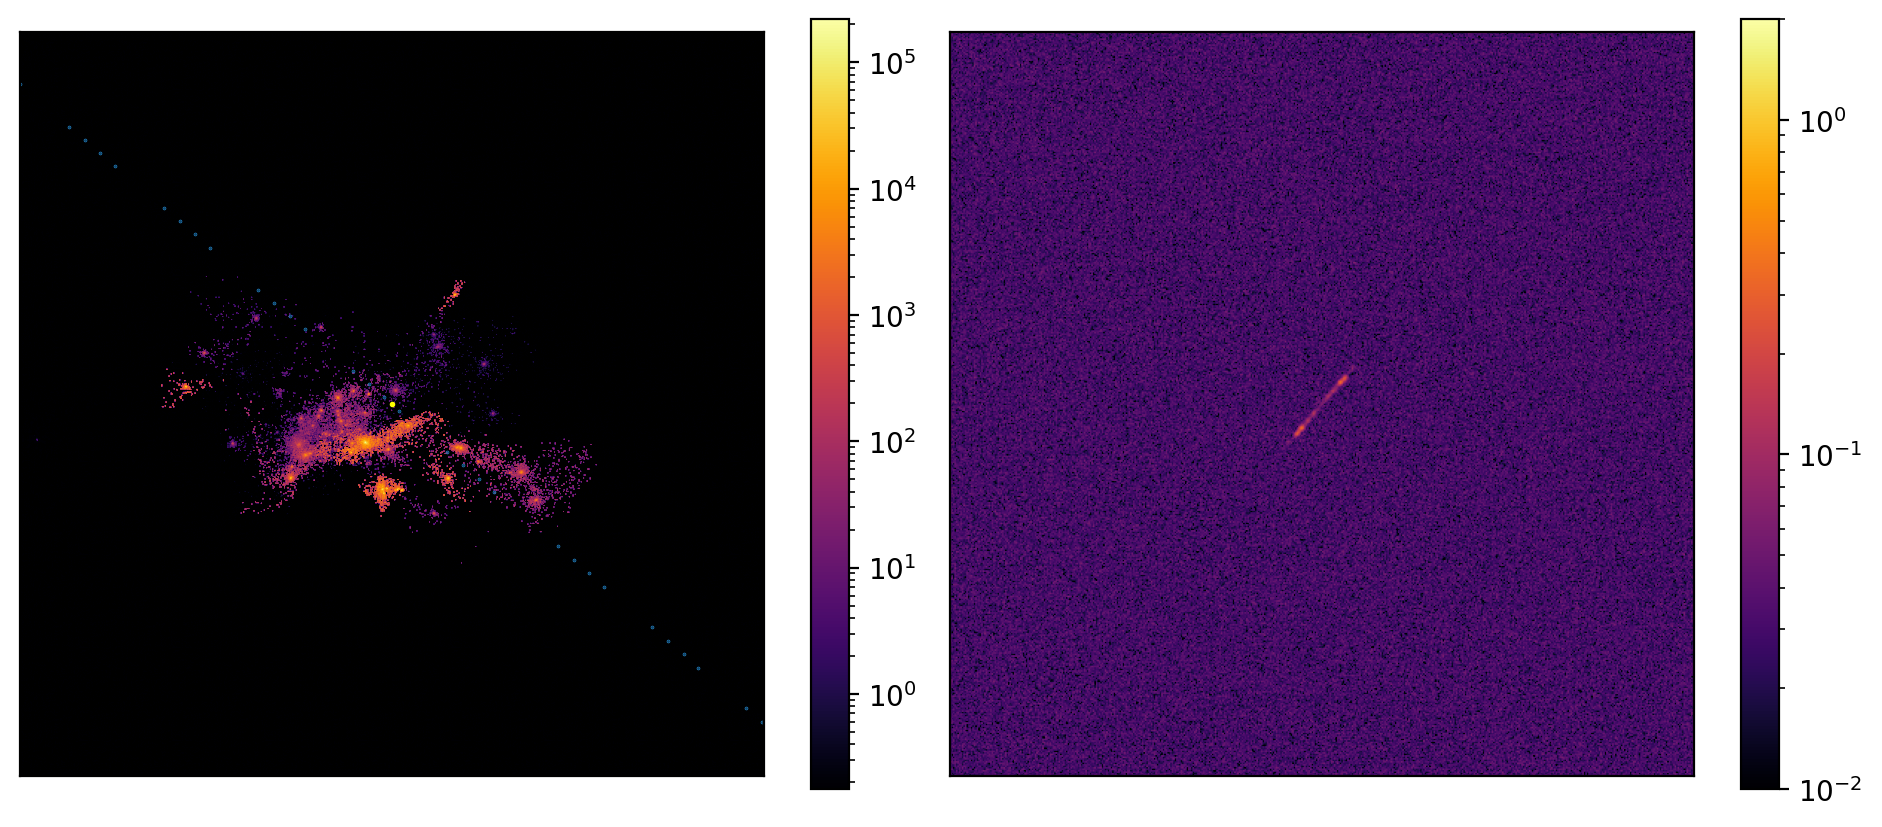

In [14]:
from matplotlib.colors import LogNorm

hw = source_pixel_scale*source_pix/2
# plot source image
extent = [source_center[0]-hw*zoom,source_center[0]+hw*zoom,source_center[1]-hw*zoom,source_center[1]+hw*zoom]
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200,gridspec_kw = {'wspace':0, 'hspace':0})
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].scatter(caustic_line[:,0],caustic_line[:,1],s=0.1)
ax[0].set_xlim(extent[:2])
ax[0].set_ylim(extent[2:])
ax[0].scatter(source_center[0],source_center[1],s=1,c="yellow")
im1 = ax[0].imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=LogNorm())
ax[0].set_facecolor('black')

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
im2 = ax[1].imshow(lensed_image, cmap='inferno',norm=LogNorm(1e-2,2))
ax[1].set_facecolor('black')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

In [ ]:
wcs = WCS(naxis=2)
wcs.wcs.crpix = [1001/2,1001/2]
wcs.wcs.cdelt = [-0.031/3600,0.031/3600]
wcs.wcs.crval = np.array([93.9795443, -57.7723101])
wcs.wcs.ctype = ["RA---TAN","DEC--TAN"]

hdu = fits.PrimaryHDU(np.flip(lensed_image,axis=0))
hdu.header.update(wcs.to_header())
hdu.writeto('spt1.fits',overwrite=True)

## Animation

  0%|                                                   | 0/790 [02:20<?, ?it/s]


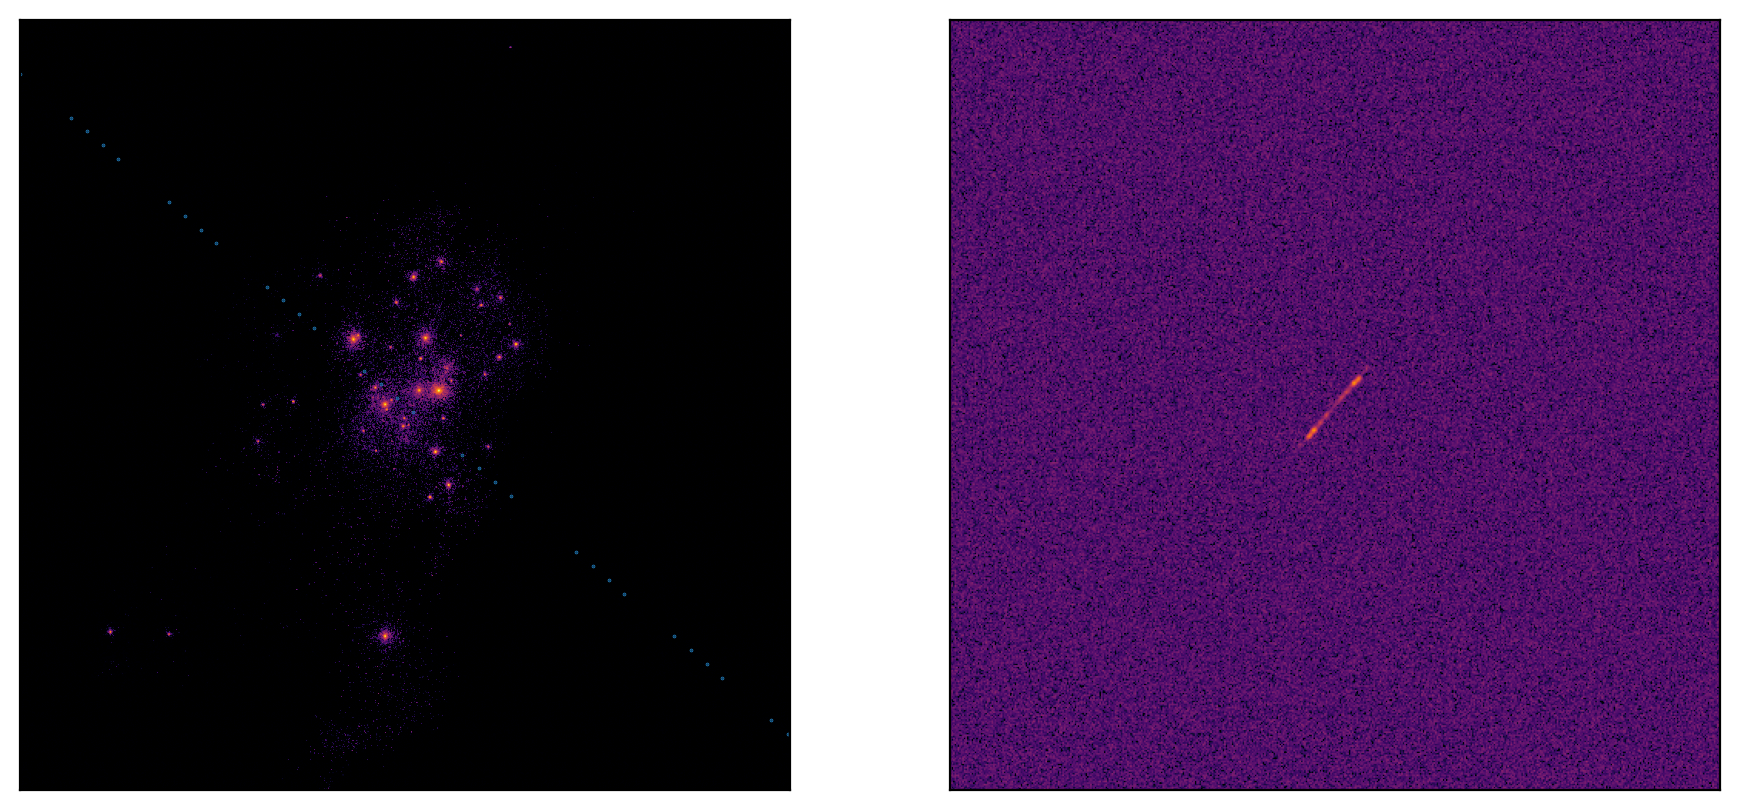

In [22]:
from tqdm import tqdm
import glob
import os
import matplotlib.animation as animation

num_frames = 789

filelist = sorted(glob.glob(os.path.join('fs07_refine/*.txt')))

zoom = 1
mag = 50
transformed_galaxy = create_source_image(filelist[500],filetype="pos")*mag
hw = source_pixel_scale*source_pix/2
# plot source image
extent = [source_center[0]-hw*zoom,source_center[0]+hw*zoom,source_center[1]-hw*zoom,source_center[1]+hw*zoom]
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200,gridspec_kw = {'wspace':0, 'hspace':0})
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].scatter(caustic_line[:,0],caustic_line[:,1],s=0.1)
ax[0].set_xlim(extent[:2])
ax[0].set_ylim(extent[2:])
im1 = ax[0].imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=LogNorm())
ax[0].set_facecolor('black')

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
im2 = ax[1].imshow(lensed_image, cmap='inferno',norm=LogNorm(1e-2,1))
ax[1].set_facecolor('black')

noise = np.random.normal(3e-2,1e-2,(image_pix,image_pix))

def init():
    return [im1,im2]

pbar = tqdm(total=num_frames,ncols=80)

def animate(i):
    pbar.update(1)
    transformed_galaxy = create_source_image(filelist[i],filetype="pos")*mag
    lensed_image = lens_image(transformed_galaxy, source_plane, traced_image_plane_corners)*image_pixel_scale**2
    lensed_image = convolve(lensed_image, Gaussian2DKernel(2.065/2.355,x_size=3,y_size=3))
    lensed_image = lensed_image + noise
    im1.set_array(transformed_galaxy)
    im2.set_array(lensed_image)
    return [im1,im2]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=num_frames, interval=100, blit=True)

In [ ]:
FFwriter = animation.FFMpegWriter(fps=30)
anim.save('evolve5.mp4', writer = FFwriter)
pbar.close()

## Polygons

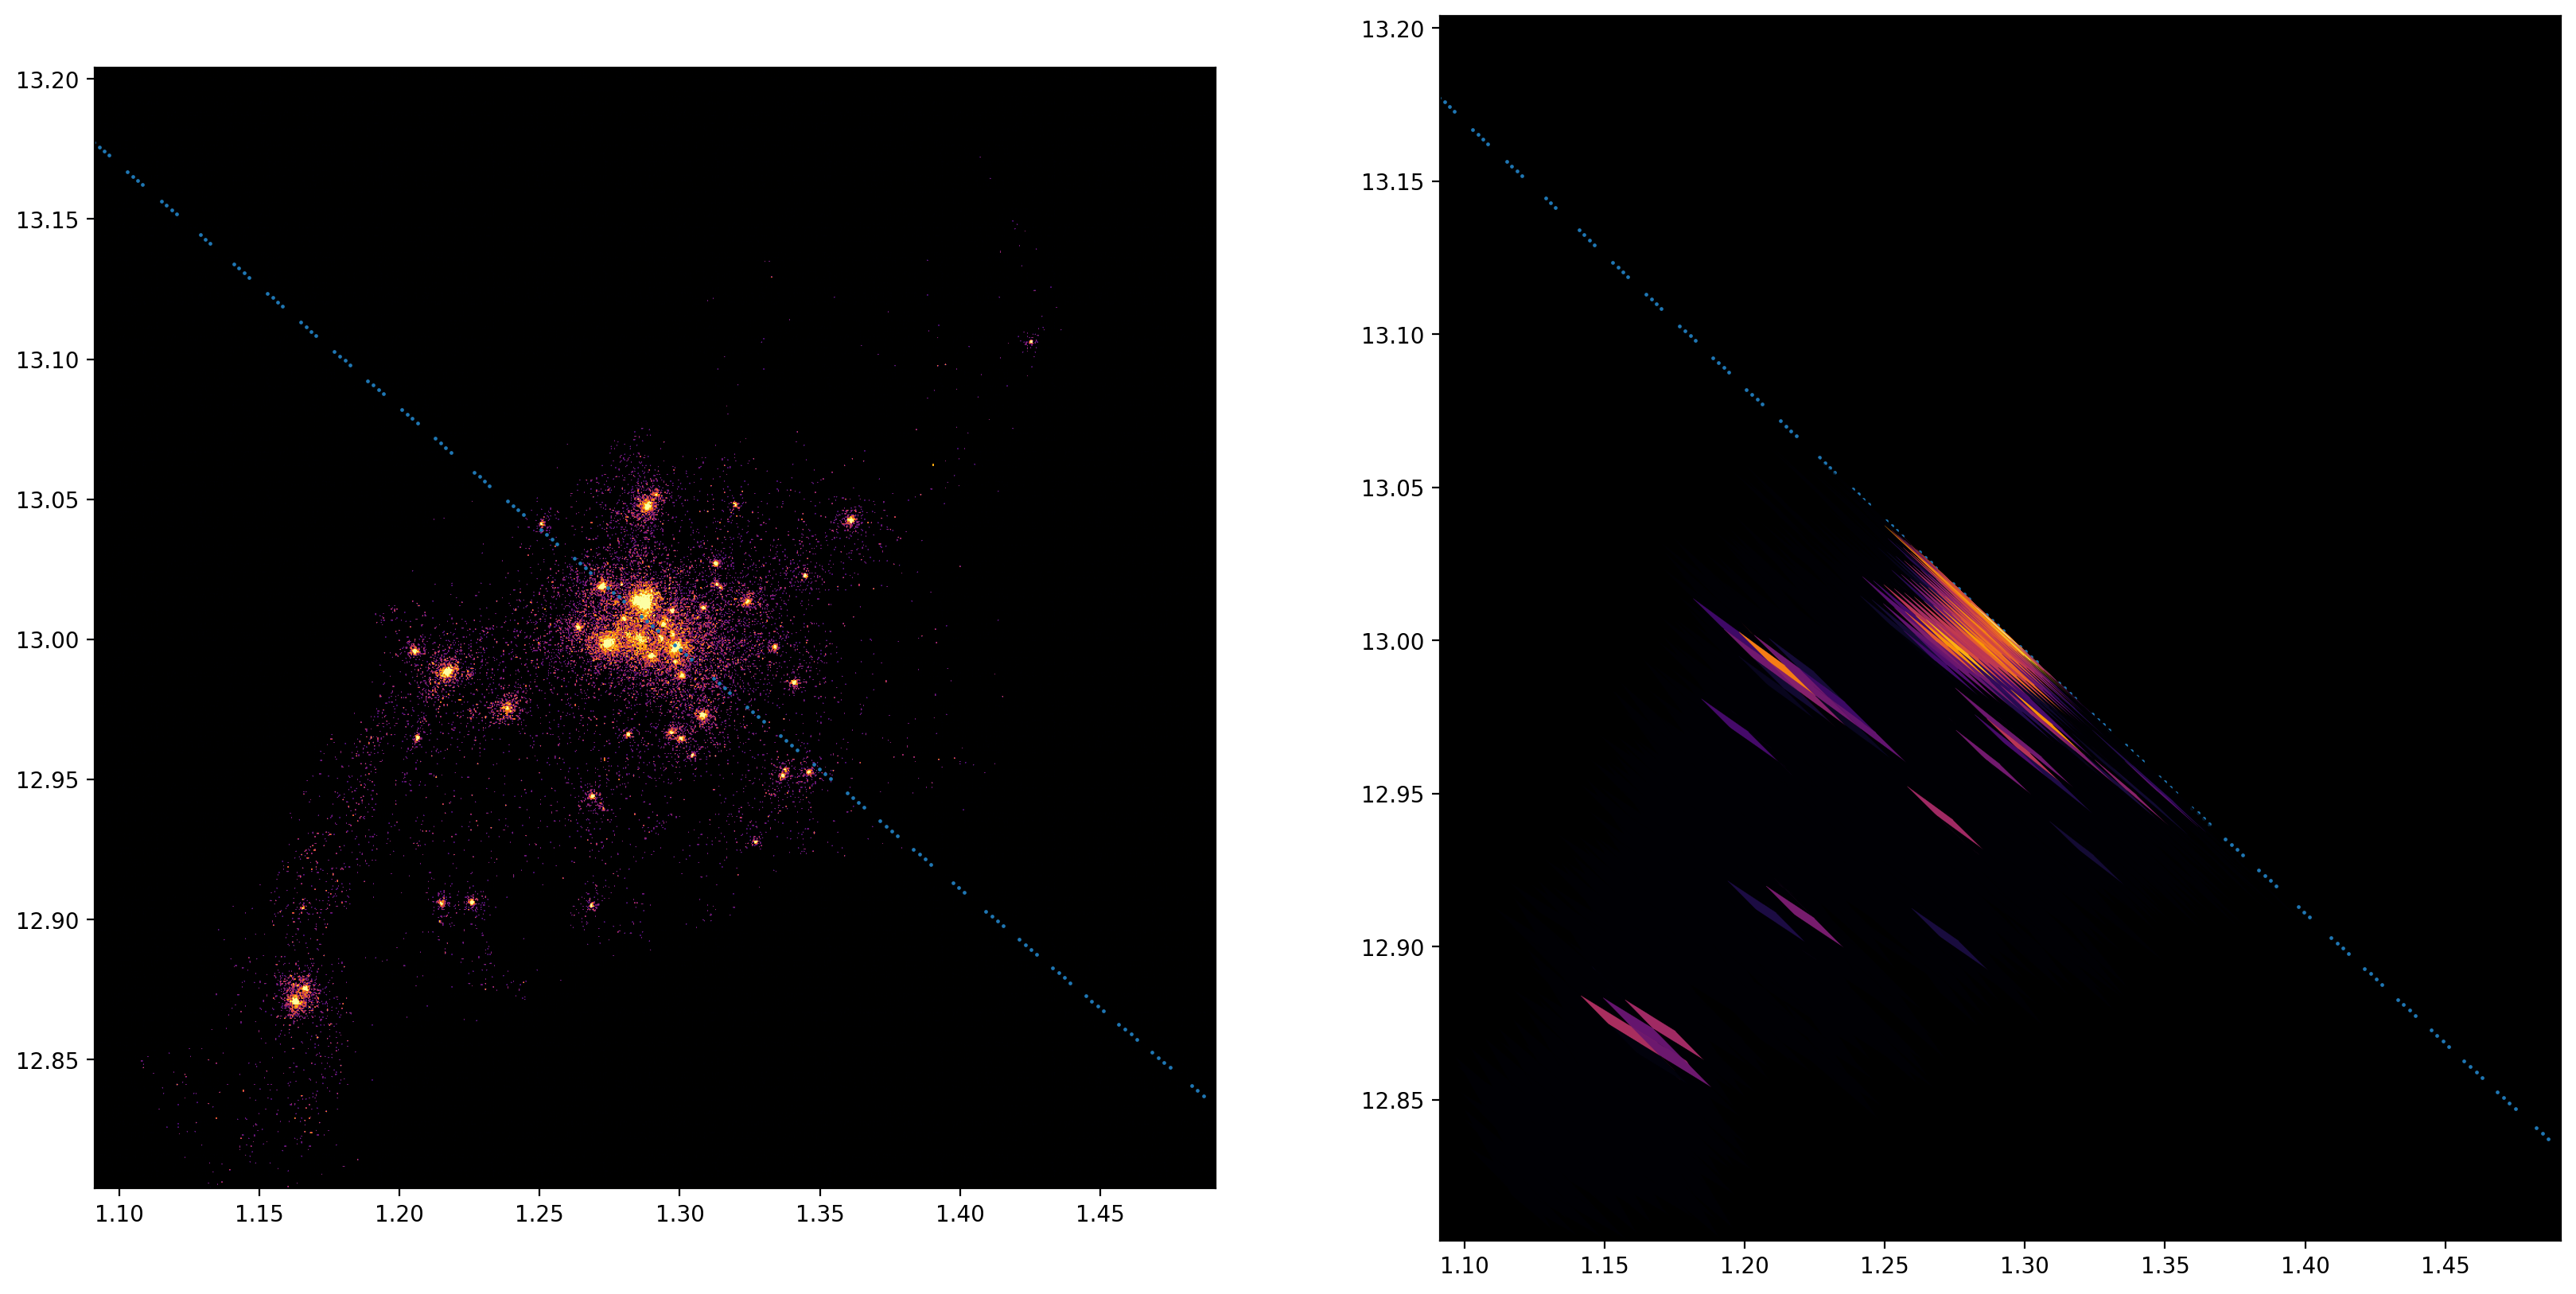

In [43]:
from matplotlib.patches import Polygon
import matplotlib as mpl

fig, ax = plt.subplots(1,2,figsize=(20,10),dpi=200)
cmap = mpl.colormaps['inferno']

lums = get_traced_luminosities(transformed_galaxy, source_plane, traced_image_plane_corners)
norm = LogNorm(vmin=1e-9,vmax=3e-8)

ax[0].imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=norm)

polygons = get_traced_pixels(source_plane,traced_image_plane_corners)
polygons = polygons[lums != 0]
lums = lums[lums != 0]
polygons = [Polygon(p,closed=True,fill=True,color=cmap(norm(lums[i])),lw=0.1) for i,p in enumerate(polygons)]
ax[0].set_xlim(extent[:2])
ax[0].set_ylim(extent[2:])
ax[1].set_xlim(extent[:2])
ax[1].set_ylim(extent[2:])
ax[0].scatter(caustic_line[:,0],caustic_line[:,1],s=0.5)
ax[1].scatter(caustic_line[:,0],caustic_line[:,1],s=0.5)
#ax[1].scatter(source_center[0],source_center[1],s=1,c="yellow")
ax[0].set_facecolor('black')
ax[1].set_facecolor('black')
for i,p in enumerate(polygons):
    ax[1].add_patch(p)

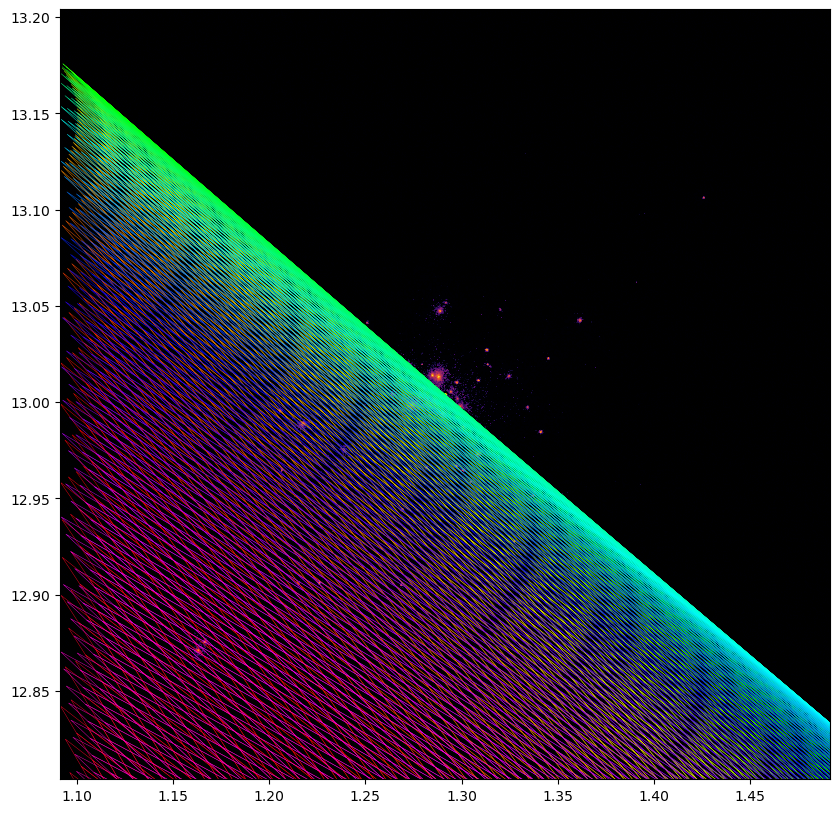

In [37]:
import matplotlib as mpl
from matplotlib.patches import Polygon

cmap = mpl.colormaps['gist_rainbow']
scale = 1
downsampled_image_plane_corners = grid(image_center, int(image_pix/scale), image_pixel_scale*scale)
downsampled_traced_image_plane_corners = ray_trace_grid(deflections_grid, x_deflections, y_deflections, downsampled_image_plane_corners)
fig, ax = plt.subplots(1,1,figsize=(10,10))
polygons = get_traced_pixels(source_plane,downsampled_traced_image_plane_corners)
num_polygons = len(polygons)
polygons = [Polygon(p,closed=True,fill=False,color=cmap(i/num_polygons),lw=0.3) for i,p in enumerate(polygons)]
ax.set_xlim(extent[:2])
ax.set_ylim(extent[2:])
# ax.set_xlim(0.15,0.2)
# ax.set_ylim(-7.7,-7.65)
ax.scatter(source_center[0],source_center[1],s=1,c="yellow")
ax.imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=LogNorm())
ax.set_facecolor('black')
for i,p in enumerate(polygons):
    ax.add_patch(p)

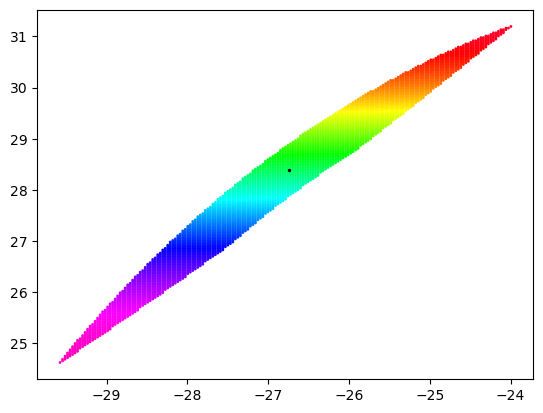

In [38]:
arc_points = get_arc_pixels(source_plane,downsampled_traced_image_plane_corners,downsampled_image_plane_corners)
colors = np.array([cmap(i/num_polygons) for i in range(num_polygons)])
plt.scatter(arc_points[:,0],arc_points[:,1],c=colors,s=1)
plt.scatter(-26.74,28.39,color="black",s=2) # plot earendel